In [1]:
import fv3fit
import intake
import vcm

In [3]:
model=fv3fit.load("/home/AnnaK/fv3net/scratch/2021-07-07-derived-model/derived_model")


In [5]:
ds = intake.open_zarr("gs://vcm-ml-experiments/2021-04-13-n2f-c3072/3-hrly-ave-rad-precip-setting-30-min-rad-timestep-shifted-start-tke-edmf-training-dataset/training_dataset.zarr").to_dask()


In [5]:
vcm.DerivedMapping._VARIABLES

{'cos_zenith_angle': <function vcm.derived_mapping.cos_zenith_angle(self)>,
 'evaporation': <function vcm.derived_mapping.evaporation(self)>,
 'dQu': <function vcm.derived_mapping.dQu(self)>,
 'dQv': <function vcm.derived_mapping.dQv(self)>,
 'eastward_wind': <function vcm.derived_mapping.eastward_wind(self)>,
 'northward_wind': <function vcm.derived_mapping.northward_wind(self)>,
 'dQu_parallel_to_eastward_wind': <function vcm.derived_mapping.dQu_parallel_to_eastward_wind_direction(self)>,
 'dQv_parallel_to_northward_wind': <function vcm.derived_mapping.dQv_parallel_to_northward_wind_direction(self)>,
 'horizontal_wind_tendency_parallel_to_horizontal_wind': <function vcm.derived_mapping.horizontal_wind_tendency_parallel_to_horizontal_wind(self)>,
 'net_shortwave_sfc_flux_derived': <function vcm.derived_mapping.net_shortwave_sfc_flux_derived(self)>}

In [9]:
import numpy as np

d = {"a": 1, "b": 2}
np.setdiff1d(
            ["b", "c"], list(d)
        )

array(['c'], dtype='<U1')

In [13]:
ds = vcm.DerivedMapping(ds.isel(time=0).merge(grid_c48)).dataset(model.input_variables)

In [3]:
vcm.DerivedMapping.derived_keys()

{'cos_zenith_angle',
 'dQu',
 'dQu_parallel_to_eastward_wind',
 'dQv',
 'dQv_parallel_to_northward_wind',
 'eastward_wind',
 'evaporation',
 'horizontal_wind_tendency_parallel_to_horizontal_wind',
 'net_shortwave_sfc_flux_derived',
 'northward_wind'}

In [14]:
prediction = model.predict_columnwise(ds, feature_dim="z")

In [16]:
prediction["net_downward_shortwave_sfc_flux_derived"]

<xarray.DataArray 'net_downward_shortwave_sfc_flux_derived' (tile: 6, y: 48, x: 48)>
dask.array<transpose, shape=(6, 48, 48), dtype=float64, chunksize=(6, 48, 48), chunktype=numpy.ndarray>
Coordinates:
    time     object 2016-08-01 02:30:00
  * tile     (tile) int64 0 1 2 3 4 5
  * x        (x) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 44.0 45.0 46.0 47.0 48.0
  * y        (y) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 44.0 45.0 46.0 47.0 48.0

In [11]:
import xarray as xr
import numpy as np
import pandas as pd
import intake
from matplotlib import pyplot as plt
from vcm.catalog import catalog
from vcm.fv3.metadata import standardize_fv3_diagnostics
import fv3viz as viz
import os
# open grid
land_sea_mask = catalog["landseamask/c48"].read()

grid_c48 = standardize_fv3_diagnostics(catalog["grid/c48"].to_dask())
ls_mask = standardize_fv3_diagnostics(catalog["landseamask/c48"].to_dask())
grid_c48 = xr.merge([grid_c48, ls_mask])

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import intake
from matplotlib import pyplot as plt
from vcm.catalog import catalog
from vcm.fv3.metadata import standardize_fv3_diagnostics
import fv3viz as viz
import os

from dask.diagnostics import ProgressBar
import warnings

import sys
sys.path.append("/home/AnnaK/explore/brianh/2021-01-04-N2F-compare-to-fine")
import add_derived


In [2]:
# paths and experiments

#CASES = ['control', 'fine-res-rad-fluxes']
#RUNS = ['nudge-to-fine-run']
verification_dycore_entry = '40day_c48_atmos_8xdaily_may2020'
verification_physics_entry = '40day_c48_gfsphysics_15min_may2020'
output_dir = '2021-05-18-N2F-c3072-compare-nudging-timescales-prognostic-runs-correct-winds'

In [3]:
# open grid
land_sea_mask = catalog["landseamask/c48"].read()

grid_c48 = standardize_fv3_diagnostics(catalog["grid/c48"].to_dask())
ls_mask = standardize_fv3_diagnostics(catalog["landseamask/c48"].to_dask())
grid_c48 = xr.merge([grid_c48, ls_mask])

MAPPABLE_VAR_KWARGS = {
    "coord_x_center": "x",
    "coord_y_center": "y",
    "coord_x_outer": "x_interface",
    "coord_y_outer": "y_interface",
    "coord_vars": {
        "lonb": ["y_interface", "x_interface", "tile"],
        "latb": ["y_interface", "x_interface", "tile"],
        "lon": ["y", "x", "tile"],
        "lat": ["y", "x", "tile"],
    },
}

In [4]:
len(grid_c48)

6

In [7]:
# load run datasets

url = "gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/initial_conditions_runs_rectified_nn_rad/20160805.000000"

drop_vars = [
    'column_heating_nudge',
    'column_moistening_nudge',
    'column_mass_tendency_nudge',
    'column_integrated_dQu',
    'column_integrated_dQv',
    'net_heating',
    'net_moistening',
    'total_precip'
]

run_datasets = []
run_case_datasets = []
#for case in CASES:

dycore = (
    standardize_fv3_diagnostics(intake.open_zarr(os.path.join(url, 'atmos_dt_atmos.zarr')).to_dask())
    .resample(time="1H", label="right").nearest()
)
physics = (
    standardize_fv3_diagnostics(intake.open_zarr(os.path.join(url, 'sfc_dt_atmos.zarr')).to_dask())
    .resample(time="1H", label="right").nearest()
)
diags = (
    standardize_fv3_diagnostics(intake.open_zarr(os.path.join(url, 'diags.zarr')).to_dask())
    .resample(time="1H", label="right").nearest()
)
merged = xr.merge([dycore, physics, diags])
ds = add_derived.physics_variables(merged).drop_vars(names=drop_vars, errors='ignore')
 

In [9]:
# compute source of moisture due to thresholding 

SECONDS_PER_DAY = 86400

def add_rectification_moisture_source(ds: xr.Dataset) -> xr.Dataset:
    
    moisture_source = ds['total_precip_to_surface'] - (SECONDS_PER_DAY*ds['PRATEsfc'] - ds['column_integrated_dQ2'])
    moisture_source = moisture_source.assign_attrs(
        {
            'long_name': 'column-integrated moisture source due to rectification',
            'units': 'mm/day'
        
        }
    )
    
    ds['column_integrated_rectification_moisture_source'] = moisture_source
    
    return ds


ds = add_rectification_moisture_source(ds)

In [10]:
# load verification dataset and subsample to hourly

verification_dycore = (
    standardize_fv3_diagnostics(catalog[verification_dycore_entry].to_dask())
    .resample(time="1H", label="right").nearest()
)
verification_physics = (
    standardize_fv3_diagnostics(catalog[verification_physics_entry].to_dask())
    .resample(time="1H", label="right").nearest()
)
verification_physics = add_derived.physics_variables(verification_physics)

common_times = list(
    set(ds.time.values).intersection(verification_dycore.time.values).intersection(verification_physics.time.values)
)

verification_dataset = xr.merge([verification_dycore, verification_physics]).sel(time=common_times)

/home/AnnaK/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 157 times more chunks
  return self.array[key]
/home/AnnaK/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]


In [49]:
TIME_MEANS = [
    'column_integrated_pQ1',
    'column_integrated_pQ2',
    'column_integrated_dQ1',
    'column_integrated_dQ2',
    'column_integrated_Q1',
    'column_integrated_Q2',
    'total_precip_to_surface',
    'column_integrated_rectification_moisture_source',
    'LHTFLsfc',
    'SHTFLsfc',
    'w500',
    'PWAT'
]

def time_mean_variable(da: xr.DataArray) -> xr.DataArray:
    time_mean_da = da.mean(dim=['time'])
    time_mean_da.attrs = da.attrs
    return time_mean_da

def add_time_means(ds: xr.Dataset) -> xr.Dataset:
    for name in TIME_MEANS:
        try:
            ds = ds.assign({f'{name}_time_mean': time_mean_variable(ds[name])})
        except KeyError:
            print(f"Variable could not be computed: {name}")
    return ds

def prognostic_time_mean_maps(ds, var, title=None, plot_cube_kwargs=None, rms_mean=None, fig_size=[12,4]):
    plot_cube_kwargs = plot_cube_kwargs or {}
    rms_mean = rms_mean or {}
    fig, axes, _, _, facetgrid = viz.plot_cube(ds, **plot_cube_kwargs)
    #print(axes[0])
    #facetgrid.set_titles(template='')
    print(axes)
    if rms_mean:
        #for i, row in enumerate(axes):
        #for j, ax in enumerate(row):
        #tau = ds[var]['timescale_hrs'].isel(timescale_hrs=j).item()
        if 'bias' in rms_mean and 'rmse' in rms_mean:
            plt.title(
                #f"{tau} hr\n"
                f"RMS: {rms_mean['rmse'][0,0]:3.2f}, \n mean: {rms_mean['bias'][0,0]:3.2f}"
            )
        elif 'bias' in rms_mean:
            plt.title(
                #f"{tau} hr \n"
                f"mean: {rms_mean['bias'][0,0]:3.2f}"
            )
    fig.set_size_inches(fig_size)
    fig.set_dpi(150)
    
def _var_rms(bias, area):
    weights = area/area.mean()
    return np.sqrt(((weights*bias)**2).mean(dim=['x', 'y', 'tile']))

def _var_mean(bias, area):
    weights = area/area.mean()
    return (weights*bias).mean(dim=['x', 'y', 'tile'])

In [14]:
ds = add_time_means(ds)
verification_dataset = add_time_means(verification_dataset)

Variable could not be computed: column_integrated_rectification_moisture_source


In [20]:
ds

<xarray.Dataset>
Dimensions:                                                    (tile: 6, x: 48, x_interface: 49, y: 48, y_interface: 49)
Coordinates:
  * tile                                                       (tile) int64 0...
    lonb                                                       (y_interface, x_interface, tile) float32 dask.array<chunksize=(49, 49, 6), meta=np.ndarray>
    latb                                                       (y_interface, x_interface, tile) float32 dask.array<chunksize=(49, 49, 6), meta=np.ndarray>
    lon                                                        (y, x, tile) float32 dask.array<chunksize=(48, 48, 6), meta=np.ndarray>
    lat                                                        (y, x, tile) float32 dask.array<chunksize=(48, 48, 6), meta=np.ndarray>
Dimensions without coordinates: x, x_interface, y, y_interface
Data variables:
    column_integrated_rectification_moisture_source_time_mean  (y, x, tile) float64 dask.array<chunksize=(48, 48, 6), meta=np.ndarray>

In [21]:
var = 'column_integrated_rectification_moisture_source_time_mean'
ds = (
    viz.mappable_var(
        ds, #xr.merge([ds, grid_c48]),
        var,
        **MAPPABLE_VAR_KWARGS
    )
)
with ProgressBar():
    ds = ds.load()
    rms_ = _var_rms(ds[var], grid_c48['area']).load()
    mean_ = _var_mean(ds[var], grid_c48['area']).load()

prognostic_time_mean_maps(
    ds,
    var,
    rms_mean=dict(rmse=rms_.values.reshape(-1,1), bias=mean_.values.reshape(-1,1)),
    plot_cube_kwargs=dict(vmin=0.0, vmax=2.5),
    fig_size=[10,5]
)
#plt.savefig(f"{output_dir}/{var}.png", facecolor='white')

[########################################] | 100% Completed | 39.5s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


KeyError: 'timescale_hrs'

< GeoAxes: <cartopy.crs.Robinson object at 0x7f186e976110> >


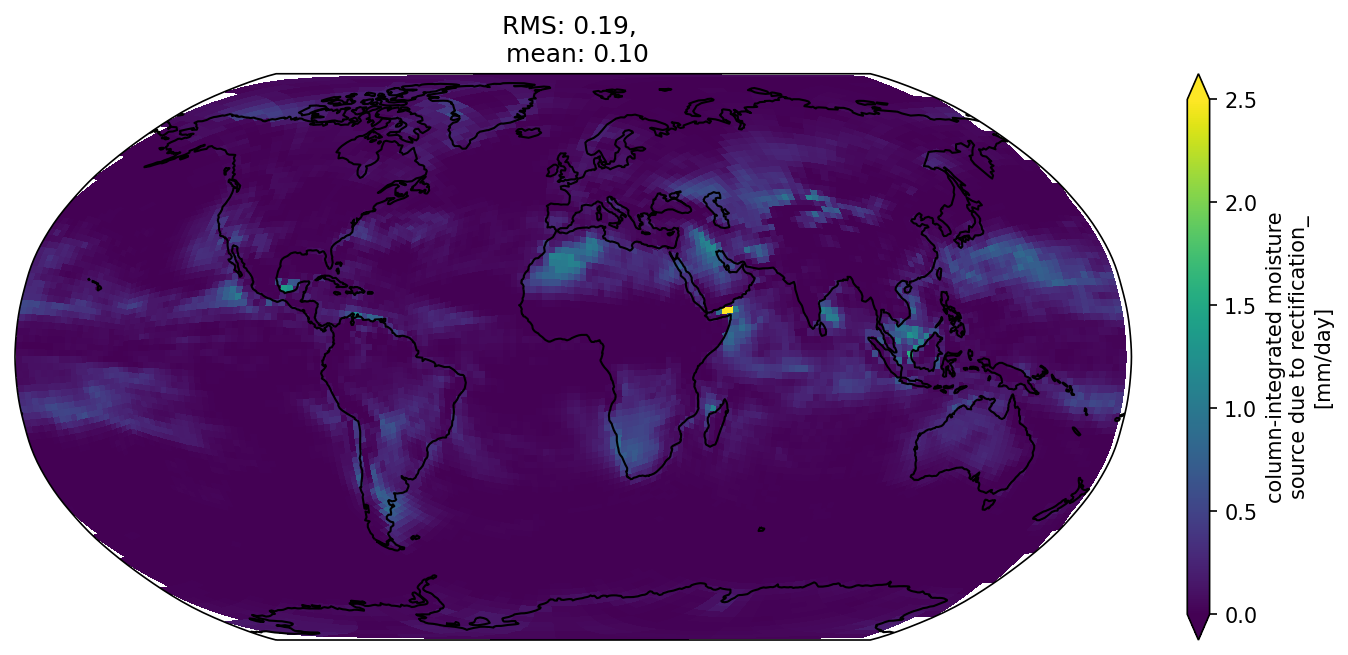

In [51]:
prognostic_time_mean_maps(
    ds,
    var,
    rms_mean=dict(rmse=rms_.values.reshape(-1,1), bias=mean_.values.reshape(-1,1)),
    plot_cube_kwargs=dict(vmin=0.0, vmax=2.5),
    fig_size=[10,5]
)

In [53]:
land_sea_mask["land_sea_mask"] == 1

<xarray.DataArray 'land_sea_mask' (tile: 6, y: 48, x: 48)>
array([[[False, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False]],

       [[False,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False,  True],
        [ True,  True,  True, ..., False,  True,  True],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * tile     (tile) int64 0 1 2 3 4 5
  * x        (x) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 44.0 45.0 46.0 47.0 48.0
  * y        (y) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 44.0 45.0 46.0 47.0 48.0

In [54]:
rms_land = _var_rms(
    ds[var], 
    grid_c48['area'].where(land_sea_mask["land_sea_mask"] == 1)
).load()
mean_land = _var_mean(
    ds[var],
    grid_c48['area'].where(land_sea_mask["land_sea_mask"] == 1)
).load()


In [57]:
rms_land.item(), mean_land.item()

(0.20513073897870374, 0.1201033600330792)